In [29]:
%matplotlib inline
import sys
import matplotlib
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import math
import scipy
from itertools import chain
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
from scipy.stats import entropy
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
from scipy.stats import norm
import re
from scipy import stats
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import zscore
from statsmodels.tsa.stattools import grangercausalitytests

### Load time series # 1 job postings
####  (BG Data Science and Data Engineering jobs 2010-2016 - accessed March 2018)

In [2]:
#1. Load time series 1
J={}
with open('time_series1.txt','r', encoding ='latin') as f:
    for line in f:
        line=line.strip()
        skill=line.split('[')[0].strip().lower() # extract skill
        vs=line.split('[')[1].split(']')[0].split(',') # vector : extract years + frequency - all content split by commas
        dic=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vs) # split year and freq
        # KEY is skill, VALUE is year, freq 
        J[skill]=dic


### Load time series # 2 publications
####  (IU WoS data 2010-2016 - accessed April 2018)

### Time series 1 and 2 must be of the same size.
### In this code, time series 2 is tested against time series 1 with IF statement:
#### if word in time series 2 IN words of time series 1, then build the dictionary

In [3]:
#2. Load time series # 2
W={}   # only skills that are matched to skills in DSDE Jobs

with open('time_series2.txt','r', encoding = 'latin') as f:
    for line in f:
        line=line.strip()
        skill=line.split('[')[0].strip().lower() # extract skill
        vsa=line.split('[')[1].split(']')[0].split(',') # vector : extract years + frequency - all content split by commas
        dica=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vsa) # split year and freq
        if skill in J:
            vs=line.split('[')[1].split(']')[0].split(',') # vector : extract years + frequency - all content split by commas
            dic=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vs) # split year and freq
            W[skill]=dic




### Load courses data frequency (MOOC, EdX, IU - see PNAS data section for more info)

In [12]:
K={}
with open('courses.txt','r', encoding = 'latin') as f1:
    for line in f1:
        a,b=line.strip().split('\t')
        K[a] = float(b)

### Data Transformation and Alignment

In [13]:
A=defaultdict(lambda:defaultdict(lambda:0))
for i in J:
    for year in range(2010,2017):
        w=J[i][year]
        if w==0:
            w=0.0001
        A[year][i]=w
        
B=defaultdict(lambda:defaultdict(lambda:0))
for i in A[2010]:
    for year in range(2010,2017):
        if i in W and year in W[i]:
            w=W[i][year]
            if w==0:
                w=0.0001
        B[year][i]=w
        
C=defaultdict(lambda:defaultdict(lambda:0))
for i in A[2010]:
    if i in K:
        if K[i]==0:
            w=0.0001
        else:
            w=K[i]
    else:
        w=0.0001
    C[i]=w

### Check the length for all three sets - it should be the same

In [15]:
len(A[2010]),len(B[2010]),len(C)

(2967, 2967, 2967)

### Check for timeline sequence

In [18]:
A.keys(), B.keys()

(dict_keys([2010, 2011, 2012, 2013, 2014, 2015, 2016]),
 dict_keys([2010, 2011, 2012, 2013, 2014, 2015, 2016]))

### Arrange data for entropy
#### Split year time series into two segments 2010-2013 and 2014-2016

In [21]:
def merge(dic,years):
    v=[]
    for i in years:
        x=np.array(list(dic[i].values()))
        x=x/float(sum(x))
        v.append(x)
    v=np.mean(v,axis=0)
    return v

In [22]:
v1=merge(B,range(2010,2014))
v2=merge(B,range(2014,2017))
vm=np.array(list(C.values()))#C.values()
v3=merge(A,range(2010,2014))
v4=merge(A,range(2014,2017))
p=np.zeros((5,5))

data=dict(zip(range(5),[v1,v2,vm,v3,v4]))
for i,j in itertools.combinations(range(5), 2):
    p[i,j]=entropy(list(data[i]),list(data[j]))

    p[j,i]=entropy(list(data[j]),list(data[i]))


In [23]:
skills=B[2010].keys() ### select words from publications and use them to extract the same words from jobs
dic1=dict(list(zip(skills,v1)))
dic2=dict(list(zip(skills,v2)))
dic3=dict(list(zip(skills,v3)))
dic4=dict(list(zip(skills,v4)))

ds=np.abs(np.mean([v1+v2],axis=0)+np.mean([v3+v4],axis=0))
dic5=dict(list(zip(skills,ds)))
sortedSkills=list(zip(*sorted(dic5.items(),key=lambda x:-x[1])))[0]

sv1=[dic1[i] for i in sortedSkills]
sv2=[dic2[i] for i in sortedSkills]
sv3=[dic3[i] for i in sortedSkills]
sv4=[dic4[i] for i in sortedSkills]

In [31]:
z =list(zip(sortedSkills,sv1,sv2,sv3,sv4))[:30]

## Popularity Ranking Plot
### Top 30 frequent words adn their probability

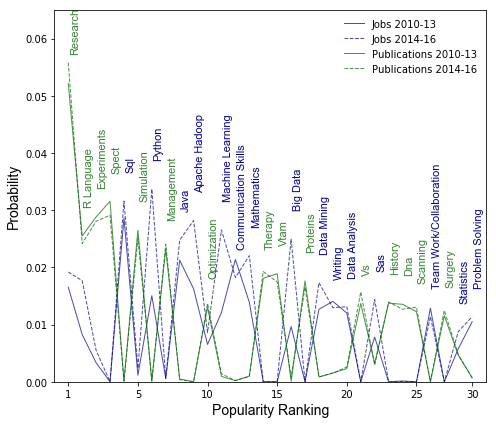

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('legend',**{'fontsize':10})
plt.rcParams['svg.fonttype'] = 'none'
np.seterr(divide='ignore', invalid='ignore') # to remove warning messages
fig = plt.figure(figsize=(7, 6),facecolor='white')
plt.rcParams['svg.fonttype'] = 'none'
plt.plot(sv3[:30],label='Jobs 2010-13',linewidth=1,color='darkblue',alpha=0.7)
plt.plot(sv4[:30],label='Jobs 2014-16',linewidth=1,color='darkblue',alpha=0.7,linestyle='--')
plt.plot(sv1[:30],label='Publications 2010-13',linewidth=1,color='darkgreen',alpha=0.7)
plt.plot(sv2[:30],label='Publications 2014-16',linewidth=1,color='darkgreen',alpha=0.7,linestyle='--')
plt.legend(loc=1,frameon=False)
n=0.1
z = list(zip(sortedSkills,sv1,sv2,sv3,sv4))[:30]
for i in range(0,len(z)):
    y=z[i][0].title()
    a1 = [z[i][1],z[i][2]]
    b1 = [z[i][3],z[i][4]]
    a= scipy.mean(a1)
    b = scipy.mean(b1)
    if a>b:
        
        plt.text(n,z[i][1]+0.005,y,color='darkgreen',size=11, alpha=0.8,rotation=90,ha='left',va='bottom',fontname="Arial")
    else:
        plt.text(n,z[i][4]+0.005,y,color='darkblue',size=11, rotation=90,ha='left',va='bottom',fontname="Arial")
    n+=1
my_xticks = ['1', '5', '10', '15', '20','25','30']
x = [0, 5, 10, 15, 20,25,29]
plt.xticks(x, my_xticks)
plt.xlim(-1,30)
plt.ylim(0,0.065)

plt.ylabel('Probability',size=14,fontname="Arial")
plt.xlabel('Popularity Ranking',size=14,fontname="Arial")
plt.tight_layout()
#plt.savefig('Probability-top30.png')
#plt.savefig('Probability-top30.pdf')
#plt.savefig('Probability-top30.svg')
plt.show()

### Kullbach-Leibler Divergence Interpolation Matrix Plot
#### Matrix data is stored in p
#### Access matrix and update plot with new values, when needed.

In [38]:
p

array([[ 0.        ,  0.01243753,  5.06627101,  6.0609289 ,  4.81030894],
       [ 0.01112007,  0.        ,  4.93169623,  6.07026114,  4.79689499],
       [ 2.84735298,  2.81255764,  0.        ,  3.66737718,  2.75261108],
       [ 4.05581675,  4.07828165,  4.86839146,  0.        ,  0.37132533],
       [ 3.91607168,  3.77028052,  3.8978138 ,  0.31485746,  0.        ]])

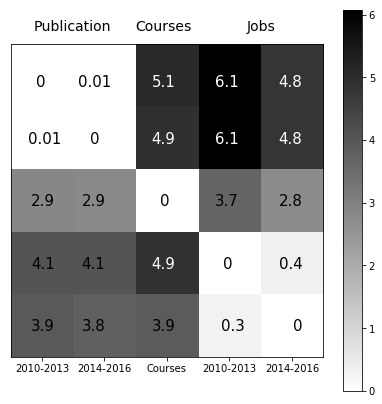

In [39]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(7, 7),facecolor='white')
plt.imshow(p, cmap='binary', interpolation='nearest') #gist_gray


my_xticks = ['2010-2013', '2014-2016', 'Courses', '2010-2013', '2014-2016']
x = [0, 1, 2, 3, 4]
plt.xticks(x, my_xticks,rotation='00')

plt.yticks([])
plt.annotate('Publication',xy=(1.1,-0.70), xytext=(0.0,1.00), ha='right', textcoords='offset points',size=14, color='black'
            , annotation_clip=False)
plt.annotate('Courses',xy=(2.4,-0.70), xytext=(0.0,1.00), ha='right', textcoords='offset points',size=14, color='black',
            annotation_clip=False)
plt.annotate('Jobs',xy=(3.74,-0.70), xytext=(0.0,1.00), ha='right', textcoords='offset points',size=14, color='black',
            annotation_clip=False)

plt.annotate('0',xy=(0.05,0.20), xytext=(0.0,1.00), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('0.01',xy=(1.1,0.20), xytext=(1,1.00), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('5.1',xy=(2.1,0.20), xytext=(2.1,1.00), ha='right', textcoords='offset points',size=15,color='white')
plt.annotate('6.1',xy=(3.1,0.20), xytext=(3.1,1.00), ha='right', textcoords='offset points',size=15,color='white')
plt.annotate('4.8',xy=(4.1,0.20), xytext=(4.1,1.00), ha='right', textcoords='offset points',size=15,color='white')

plt.annotate('0.01',xy=(0.3,1.10), xytext=(0.4,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('0',xy=(0.9,1.1), xytext=(1,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('4.9',xy=(2.1,1.10), xytext=(2.1,1.10), ha='right', textcoords='offset points',size=15,color='white')
plt.annotate('6.1',xy=(3.1,1.10), xytext=(3.1,1.10), ha='right', textcoords='offset points',size=15,color='white')
plt.annotate('4.8',xy=(4.1,1.10), xytext=(4.1,1.10), ha='right', textcoords='offset points',size=15,color='white')

plt.annotate('2.9',xy=(0.2,2.10), xytext=(0.4,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('2.9',xy=(1,2.10), xytext=(1,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('0',xy=(2.0,2.10), xytext=(2.1,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('3.7',xy=(3.1,2.10), xytext=(3.1,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('2.8',xy=(4.1,2.10), xytext=(4.1,1.10), ha='right', textcoords='offset points',size=15)

plt.annotate('4.1',xy=(0.2,3.10), xytext=(0.4,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('4.1',xy=(1,3.10), xytext=(1,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('4.9',xy=(2.1,3.10), xytext=(2.1,1.10), ha='right', textcoords='offset points',size=15,color='white')
plt.annotate('0',xy=(3.0,3.10), xytext=(3.1,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('0.4',xy=(4.1,3.10), xytext=(4.1,1.10), ha='right', textcoords='offset points',size=15, color='black')

plt.annotate('3.9',xy=(0.2,4.10), xytext=(0.4,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('3.8',xy=(1,4.10), xytext=(1,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('3.9',xy=(2.1,4.10), xytext=(2.1,1.10), ha='right', textcoords='offset points',size=15)
plt.annotate('0.3',xy=(3.2,4.10), xytext=(3.1,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.annotate('0',xy=(4.1,4.10), xytext=(4.1,1.10), ha='right', textcoords='offset points',size=15, color='black')
plt.margins(0.2)

plt.colorbar()
#plt.savefig('KL-entropy.png')
#plt.savefig('KL-entropy.svg')

plt.show()